In [1]:
from cryoS2Sdrop.analyze import *
from cryoS2Sdrop.deconvolution import tom_deconv_tomo
from skimage import exposure

PARENT_PATH = setup.PARENT_PATH

pd.options.display.float_format = "{:,.6f}".format
pd.set_option('display.max_columns', 50)

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

def plot_centralSlices(tomo_data, set_axis_off, names=None):
    shape = np.array(tomo_data.shape)
    idx_central_slices = shape//2
    ratios = shape/shape.max()
    
    fig, ax = plt.subplots(1, 3, figsize=(25, 10), gridspec_kw={'width_ratios': ratios})  
    if set_axis_off:
        list(map(lambda axi: axi.set_axis_off(), ax.ravel()))
        
    plt.tight_layout()
    
    if names is None:
        names = ['Central XY plane', 'Central ZX plane', 'Central ZY plane']
    
    for i in range(3):
        tomo_slice = np.take(tomo_data, idx_central_slices[i], axis=i)
        ax[i].imshow(tomo_slice)
        ax[i].set_title(names[i], fontsize=16)
    
    plt.show()
    
    return fig, ax

def make_shell(inner_radius, outer_radius, tomo_shape):
    """
    Creates a (3D) shell with given inner_radius and delta_r width centered at the middle of the array.

    """

    length = min(tomo_shape)
    if length % 2 == 1:
        length = length - 1

    mask_shape = len(tomo_shape) * [length]
    _shell_mask = np.zeros(mask_shape)

    # only do positive quadrant first
    for z in range(0, outer_radius + 1):
        for y in range(0, outer_radius + 1):
            for x in range(0, outer_radius + 1):

                r = np.linalg.norm([z, y, x])

                if r >= inner_radius and r < outer_radius:
                    zidx = z + length // 2
                    yidx = y + length // 2
                    xidx = x + length // 2

                    _shell_mask[zidx, yidx, xidx] = 1

    aux = (
        np.rot90(_shell_mask, axes=(0, 1))
        + np.rot90(_shell_mask, 2, axes=(0, 1))
        + np.rot90(_shell_mask, 3, axes=(0, 1))
    )

    _shell_mask = _shell_mask + aux  # this is half the volume

    aux = np.rot90(
        _shell_mask, 2, axes=(1, 2)
    )  # rotate again 180º to get full volume

    aux2 = _shell_mask + aux

    if inner_radius == 0:
        vol = 4 / 3 * np.pi * outer_radius**3
        pct_diff = (vol - aux2.sum()) / vol
        if pct_diff > 0.1:
            print(pct_diff)
            raise ValueError("Sanity check for sphere volume not passed")

    # finally, fill the actual shape of the tomogram with the mask
    shell_mask = np.zeros(tomo_shape)
    shell_mask[
        (tomo_shape[0] - length) // 2 : (tomo_shape[0] + length) // 2,
        (tomo_shape[1] - length) // 2 : (tomo_shape[1] + length) // 2,
        (tomo_shape[2] - length) // 2 : (tomo_shape[2] + length) // 2,
    ] = aux2

    return shell_mask

def create_hiFreqMask(tomo_shape, fourier_tomo_shape):
    "Randomly mask high frequencies with a sphere"
    inner = 0
    shape_vol = np.array(tomo_shape).prod()
    low_r = (0.05 * 3/(4*np.pi) * shape_vol)**(1/3)
    high_r = (0.1 * 3/(4*np.pi) * shape_vol)**(1/3)
    outer = np.random.uniform(low_r, high_r)
    outer = int(np.round(outer))
    
    shell_mask = make_shell(inner, outer, tomo_shape)
    # up to this point we have a shell for the shifted (centered) full spectrum
    shell_mask = torch.tensor(shell_mask)
    # # make shell correspond to the unshifted spectrum
    # shell_mask = torch.fft.ifftshift(shell_mask)
    # # make it correspond to only real part of spectrum
    # shell_mask = shell_mask[..., 0 : fourier_tomo_shape[-1]]

    return shell_mask.float().numpy()

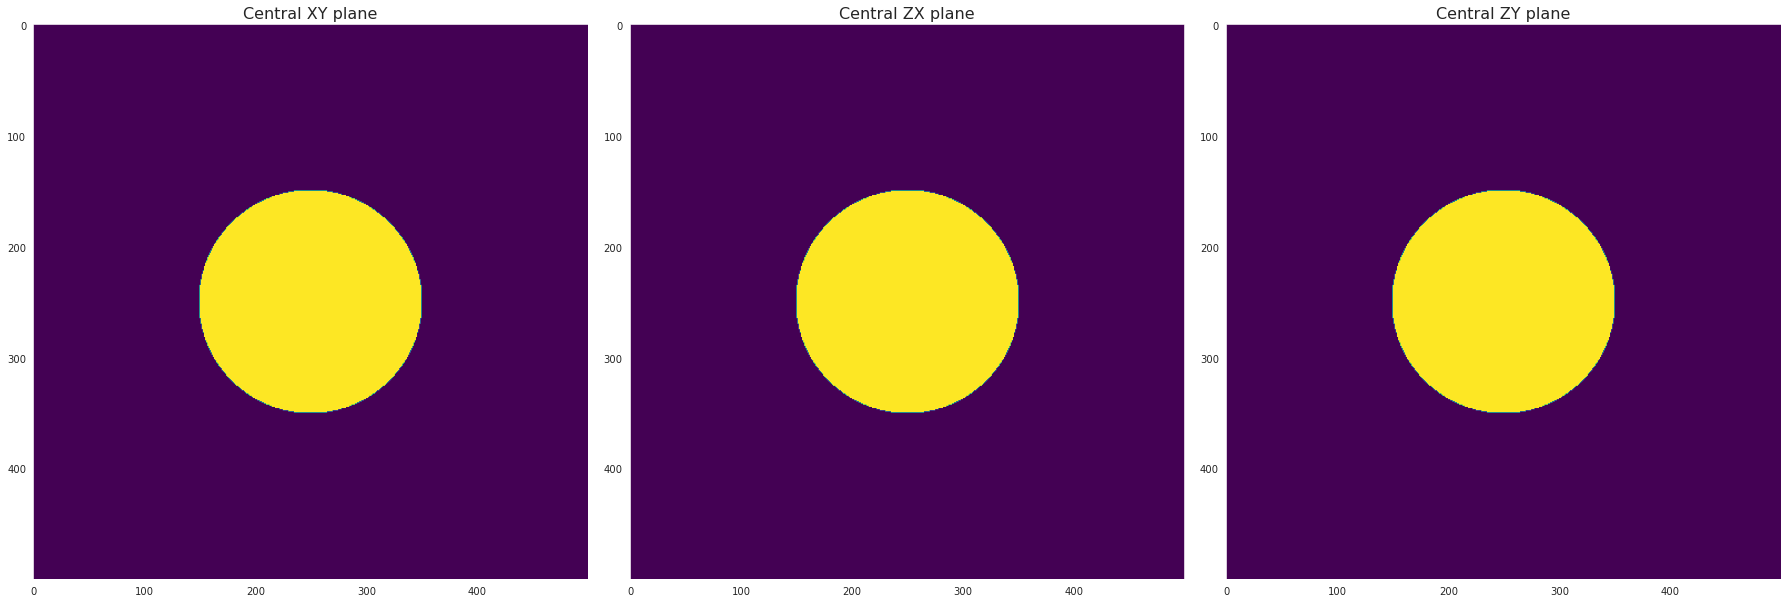

(<Figure size 1800x720 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Central XY plane'}>,
        <AxesSubplot:title={'center':'Central ZX plane'}>,
        <AxesSubplot:title={'center':'Central ZY plane'}>], dtype=object))

In [2]:
tomo_shape = [500, 500, 500]
shell = make_shell(0, 100, tomo_shape)

plot_centralSlices(shell, False)

In [243]:
def _make_shell(inner_radius, outer_radius, tomo_shape):
    """
    Creates a (3D) shell with given inner_radius and outer_radius centered at the middle of the array.

    """

    length = min(tomo_shape)
    if length % 2 == 1:
        length = length - 1

    mask_shape = len(tomo_shape) * [length]
    _shell_mask = np.zeros(mask_shape)

    # only do positive quadrant first
    for z in range(0, outer_radius + 1):
        for y in range(0, outer_radius + 1):
            for x in range(0, outer_radius + 1):

                r = np.linalg.norm([z, y, x])

                if r >= inner_radius and r < outer_radius:
                    zidx = z + length // 2
                    yidx = y + length // 2
                    xidx = x + length // 2

                    _shell_mask[zidx, yidx, xidx] = 1

    aux = (
        np.rot90(_shell_mask, axes=(0, 1))
        + np.rot90(_shell_mask, 2, axes=(0, 1))
        + np.rot90(_shell_mask, 3, axes=(0, 1))
    )

    _shell_mask = _shell_mask + aux  # this is half the volume

    aux = np.rot90(
        _shell_mask, 2, axes=(1, 2)
    )  # rotate again 180º to get full volume
    
    _shell_mask += aux
    
    return _shell_mask

def make_shell2(inner_radius, outer_radius, tomo_shape, factor):
    """
    Creates a (3D) shell with given inner_radius and delta_r width centered at the middle of the array.

    """
    
    length = min(tomo_shape)
    if length % 2 == 1:
        length = length - 1
        
    if 2*radius>length:
        raise ValueErroreError('Cannot fit a bigger sphere than the smallest tomogram length.')
    
    if factor % 2 == 1:
        raise ValueError('factor values must be divisible by 2')
        
    upsample = torch.nn.Upsample(scale_factor=factor)
        
    length_down = length//factor 

    mask_shape = len(tomo_shape) * [length_down]
    
    tomo_shape_down = np.array(tomo_shape)//factor
    outer_radius_down = int(np.round(outer_radius/factor))
    inner_radius_down = int(np.round(inner_radius/factor))

    _shell_mask = _make_shell(inner_radius_down, outer_radius_down, tomo_shape_down)
    
    _shell_mask = torch.tensor(_shell_mask).unsqueeze(0).unsqueeze(0)
    _shell_mask = upsample(_shell_mask).squeeze().numpy()

    if inner_radius == 0:
        vol = 4 / 3 * np.pi * outer_radius**3
        pct_diff = (vol - _shell_mask.sum()) / vol
        if pct_diff > 0.1:
            print(pct_diff)
            raise ValueError("Percentual difference between the created sphere and the actual volume of a sphere of the given radius is bigger than 0.1")
    
    # finally, pad shape to correspond the original shape
    shape_diff = np.array(tomo_shape) - np.array(_shell_mask.shape)
    shape_diff = shape_diff//2 + 1
    _shell_mask = np.pad(_shell_mask, [(shape_diff[0], ), (shape_diff[1], ), (shape_diff[2], )])

    shell_mask =  _shell_mask[0:tomo_shape[0], 0:tomo_shape[1], 0:tomo_shape[2]]
    
    return shell_mask

(464, 464, 464)


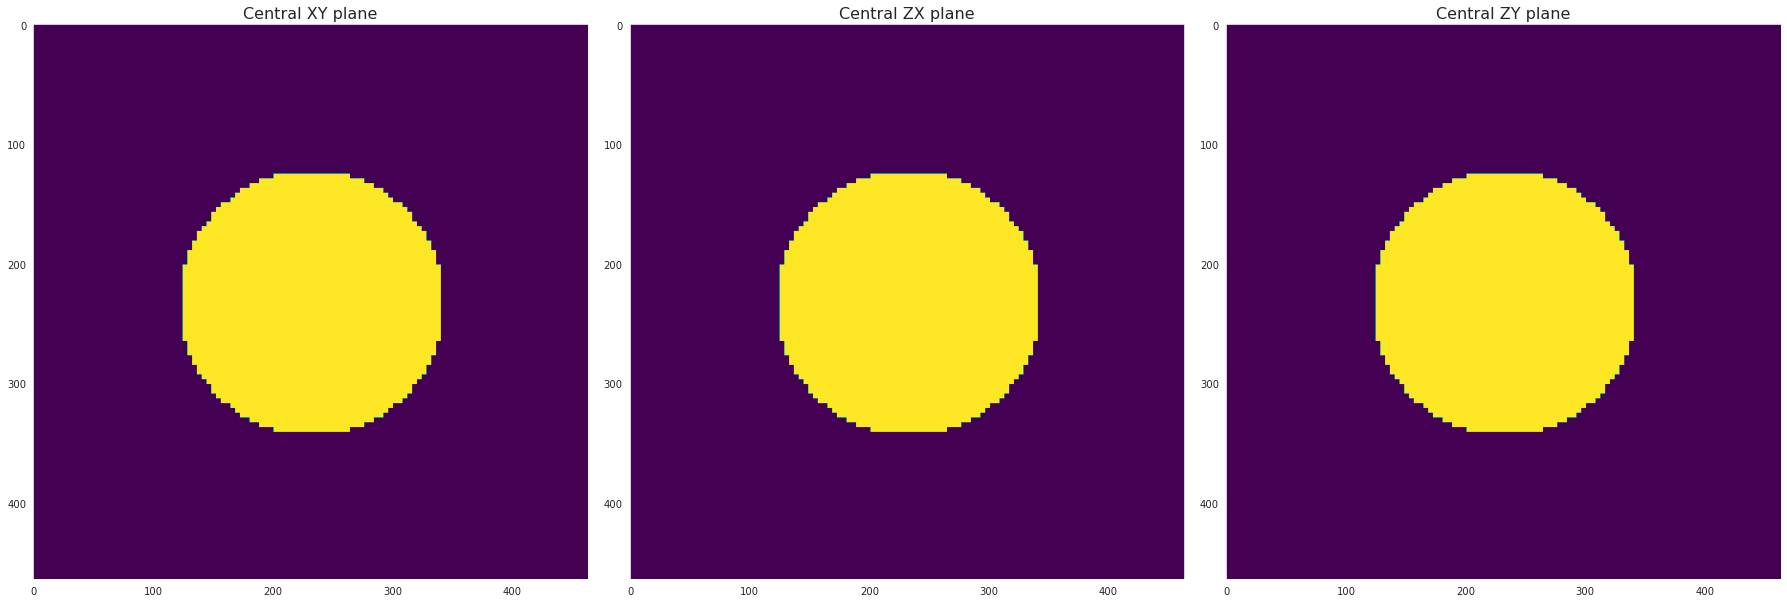

(<Figure size 1800x720 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Central XY plane'}>,
        <AxesSubplot:title={'center':'Central ZX plane'}>,
        <AxesSubplot:title={'center':'Central ZY plane'}>], dtype=object))

In [246]:
tomo_shape = [464, 464, 464]

shape_vol = np.array(tomo_shape).prod()
low_r = (0.05 * 3/(4*np.pi) * shape_vol)**(1/3)
high_r = (0.1 * 3/(4*np.pi) * shape_vol)**(1/3)
radius = np.random.uniform(low_r, high_r)
factor = 4

shell2 = make_shell2(0, radius, tomo_shape, factor)


print(shell2.shape)
plot_centralSlices(shell2, False)

In [240]:
%%timeit 
make_shell2(0, radius, tomo_shape, factor=1)

53 s ± 1.65 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [229]:
%%timeit 
make_shell2(0, radius, tomo_shape, factor=2)

8.22 s ± 415 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [230]:
%%timeit
make_shell2(0, radius, tomo_shape, factor=4)

3.03 s ± 336 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [221]:
%%timeit 
make_shell(0, int(radius), tomo_shape)

43.2 s ± 966 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [241]:
def create_hiFreqMask2(tomo_shape, fourier_tomo_shape):
    "Randomly mask high frequencies with a sphere"
    inner = 0
    shape_vol = np.array(tomo_shape).prod()
    low_r = (0.05 * 3/(4*np.pi) * shape_vol)**(1/3)
    high_r = (0.1 * 3/(4*np.pi) * shape_vol)**(1/3)
    outer = np.random.uniform(low_r, high_r)
    outer = int(np.round(outer))
    
    shell_mask = make_shell2(inner, outer, tomo_shape, 2)
    # up to this point we have a shell for the shifted (centered) full spectrum
    shell_mask = torch.tensor(shell_mask)
    # # make shell correspond to the unshifted spectrum
    # shell_mask = torch.fft.ifftshift(shell_mask)
    # # make it correspond to only real part of spectrum
    # shell_mask = shell_mask[..., 0 : fourier_tomo_shape[-1]]

    return shell_mask.float().numpy()

In [242]:
mask = create_hiFreqMask2(tomo_shape, tomo_shape)
mask.shape

(464, 928, 928)